# Access AWS CESM2 using the AWS open data origin data 

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
# import s3fs
import seaborn as sns
import re
# import nest_asyncio
# nest_asyncio.apply()
import aiohttp

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
# file = PelicanMap('/chtc/PUBLIC/eturetsky/ncar-subset/ncar/monthly/cesm2LE-historical-cmip6-FLUT.zarr', pelfs)
# test = xr.open_dataset(file, engine='zarr')
# test

In [5]:
# File paths
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
#
rda_data           = '/gpfs/csfs1/collections/rda/data/'
new_intake_path    = rda_data + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.json'
new_intake_csvpath = rda_data + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.csv'

### Set up osdf url to use with PelicanFS
- We should one of the two pelicanFS FSSpec protocols ('osdf' or 'pelican') instead of the https protocol.
- We will use the 'osdf' protocol and modify the existing CESM2-LENS catalog
- So, the urls will look like: osdf_discovery_url + namespace prefix + path to file or object
- In this case, the urls will look like osdf:///aws-opendata/us-west-2/ncar-cesm2-lens + path to individual zarr stores

In [6]:
s3_link  = 's3://'
# osdf_url = 'https://osdf-director.osg-htc.org/aws-opendata/us-west-2/'
osdf_url = 'osdf:///aws-opendata/us-west-2/'
#
rda_url        =  'https://data.rda.ucar.edu/'
new_intake_url = rda_url + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.json'

In [8]:
%%time
pelfs = OSDFFileSystem() # OSDFFileSystem is already aware of the osdf discovery url
#pelfs = PelicanFileSystem("pelican://osg-htc.org")
# pelfs.ls('/ncar/rda/')

CPU times: user 1.35 ms, sys: 423 μs, total: 1.78 ms
Wall time: 3.52 ms


In [9]:
%%time
# pelfs = PelicanFileSystem("https://osdf-director.osg-htc.org/")
pelfs.ls('/aws-opendata/us-west-2/ncar-cesm2-lens/')

CPU times: user 22.2 ms, sys: 890 μs, total: 23.1 ms
Wall time: 1 s


[]

In [10]:
# Try to create a file url following Emma's example
cesm2_lens_path  = '/aws-opendata/us-west-2/ncar-cesm2-lens/'
#osdf_director    = 'https://osdf-director.osg-htc.org/'
zarr_path        = cesm2_lens_path + 'atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr'
#
pel_zarr         = PelicanMap(zarr_path, pelfs)
print(zarr_path)

/aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr


- Note the extra `/' in between the (pelican_director url + cesm2_lens_path). This is required

In [11]:
%%time
# Now, try to access the zarr store using open_zarr
test_zarr = xr.open_zarr(pel_zarr).TREFHT
#test_zarr = xr.open_mfdataset(pel_zarr, engine='zarr') 
test_zarr

CPU times: user 446 ms, sys: 59.2 ms, total: 505 ms
Wall time: 11.5 s


<xarray.DataArray 'TREFHT' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
dask.array<open_dataset-TREFHT, shape=(50, 60225, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [12]:
%%time
#Using HTTPS protocol
#test = xr.open_dataset('https://osdf-director.osg-htc.org/aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr',\
#                       engine='zarr').TREFHT
#Using pelicanfs' OSDF protocol
test = xr.open_dataset('osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-TREFHT.zarr',\
                       engine='zarr').TREFHT
test

CPU times: user 96.2 ms, sys: 7.09 ms, total: 103 ms
Wall time: 244 ms


<xarray.DataArray 'TREFHT' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
[166510080000 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

# Comments
- PelicanFs doesn't seem to support the 'ls' command
- However, we can load the zarr store using the full url/ pelfs 
- So, let us try using an intake catalog
- The original intake catalog can be found at 'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
- Let us modify this catalog, by pre-pending the s3 path to the object ncar-cesm2-lens with the osdf-director + namespace
- The size of this catalog is > 100 MB. So, let us not upload it to a github repo
- Let us save the catalog to a folder on NCAR's disk storage

## Modify the intake catalog

In [13]:
# Open collection description file using intake
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)
catalog

,unique
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20
start_time,4


In [14]:
df_s3 = catalog.df
df_s3['path']

0      s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
1      s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
2      s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
3      s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
4      s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
                             ...                        
317    s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp37...
318            s3://ncar-cesm2-lens/ocn/static/grid.zarr
319            s3://ncar-cesm2-lens/ocn/static/grid.zarr
320            s3://ncar-cesm2-lens/ocn/static/grid.zarr
321            s3://ncar-cesm2-lens/ocn/static/grid.zarr
Name: path, Length: 322, dtype: object

In [15]:
# # Change s3 paths to osdf paths
# df_s3['path'] = df_s3['path'].str.replace(s3_link, '')
# df_s3['path'] = osdf_url + df_s3['path'] 
# df_s3['path'].head().values

array(['osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr'],
      dtype=object)

In [16]:
# %%time
# df_s3.to_csv(new_intake_csvpath)

CPU times: user 4.84 ms, sys: 466 μs, total: 5.31 ms
Wall time: 424 ms


## Test the new intake catalog after spinning up a cluster

In [17]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '5:00:00',
    log_directory = rda_scratch+'/dask/logs',
    #interface = 'ib0'
    interface = 'ext'
)

In [18]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38695/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38695/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.93:34511,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38695/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [19]:
cluster.scale(4)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38695/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.93:34511,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38695/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Access the data from the AWS bucket using intake to compare

In [20]:
osdf_catalog = intake.open_esm_datastore(
    new_intake_path
)
osdf_catalog

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [21]:
osdf_catalog.df['path'].head().values

array(['osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr'],
      dtype=object)

In [22]:
osdf_catalog_temp = osdf_catalog.search(variable ='TREFHTMX', frequency ='daily')
osdf_catalog_temp

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [23]:
%%time
#dsets = osdf_catalog_temp.to_dataset_dict(storage_options={'anon':True})
dsets = osdf_catalog_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


CPU times: user 1.22 s, sys: 237 ms, total: 1.45 s
Wall time: 1min 2s


In [24]:
%%time
dsets.keys()

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.77 μs


dict_keys(['atm.ssp370.daily.cmip6', 'atm.historical.daily.smbb', 'atm.ssp370.daily.smbb', 'atm.historical.daily.cmip6'])

In [25]:
historical_smbb = dsets['atm.historical.daily.smbb']
historical_smbb

<xarray.Dataset> Size: 666GB
Dimensions:    (member_id: 50, time: 60225, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, nbnd) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHTMX   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                       CF-1.0
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  day_1
    topography_file:                   /mnt/lustre/share/CESM/cesm_input/atm/...
    ...                                ...
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         2014-12-31 12:00:00
    intake_esm_attrs:path:             osdf:///aws-opendata/us-west-2/ncar-ce...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.daily.smbb

CPU times: user 4.52 s, sys: 831 ms, total: 5.35 s
Wall time: 5min 1s


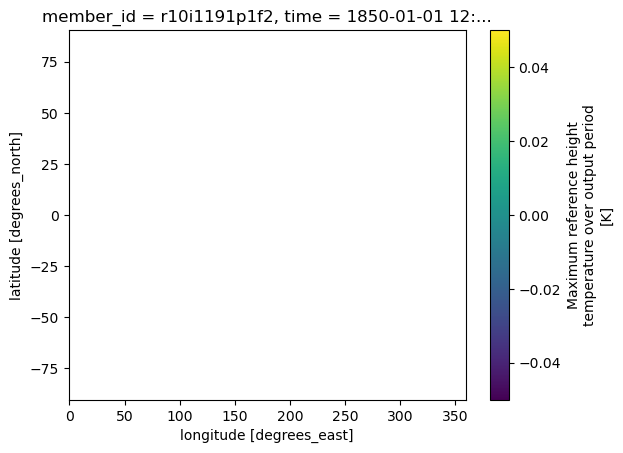

In [26]:
%%time
historical_smbb.TREFHTMX.isel(member_id=0,time=0).plot()